In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(False) # Needed for reproducible results

In [ ]:
# %pip install --upgrade torchmetrics[image] torch-fidelity

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

CelebA dataset stored on student google drive. Need to mount drive in order to access

In [ ]:
# MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# CHECK NUMBER OF IMAGES IN DATA FOLDER
image_folder = '/content/drive/MyDrive/EC503 Project/Data/img_align_celeba' # Student drive location
print("Number of images:", len([f for f in os.listdir(image_folder) if f.endswith('.jpg')]))

In [ ]:
# THIS BLOCK OF CODE SETS US UP FOR TRAINING
# Root directory for dataset
dataroot = '/content/drive/MyDrive/EC503 Project/Data/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# CREATE THE DATASET
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# GENERATOR
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# DISCRIMINATOR
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# SETTING UP LOSS, OPTIMIZER, AND EVAL METRICS
# Initialize the ``BCELoss`` function, FID and IS computations
criterion = nn.BCELoss()
fid = FrechetInceptionDistance(feature=2048).to(device)
is_metric = InceptionScore(feature=2048).to(device)

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# THIS CODE IS THE TRAINING LOOP
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
FID_scores = []
IS_scores = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    G_epoch_loss = 0.0
    D_epoch_loss = 0.0
    num_batches = 0

    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        G_epoch_loss += errG.item()
        D_epoch_loss += errD.item()
        num_batches += 1

    # Save Losses for plotting later
    G_losses.append(G_epoch_loss / num_batches)
    D_losses.append(D_epoch_loss / num_batches)

    # ---- Evaluate on 1000 samples ----
    netG.eval()
    real_batch = next(iter(dataloader))[0][:1000].to(device)
    real_uint8 = ((real_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)

    with torch.no_grad():
        noise = torch.randn(1000, nz, 1, 1, device=device)
        fake_batch = netG(noise)
        fake_uint8 = ((fake_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)

    # Compute FID
    fid.reset()
    for i in range(0, real_uint8.size(0), 100):
      fid.update(real_uint8[i:i+100].to(device), real=True)
    for i in range(0, fake_uint8.size(0), 100):
      fid.update(fake_uint8[i:i+100].to(device), real=False)

    fid_val = fid.compute().item()
    FID_scores.append(fid_val)

    # Compute Inception Score
    is_metric.reset()
    for i in range(0, fake_uint8.size(0), 100):
      is_metric.update(fake_uint8[i:i+100].to(device))
    is_val, _ = is_metric.compute()
    IS_scores.append(is_val.item())

    print(f"Epoch {epoch+1}/{num_epochs} | FID: {fid_val:.2f} | IS: {is_val:.2f}")



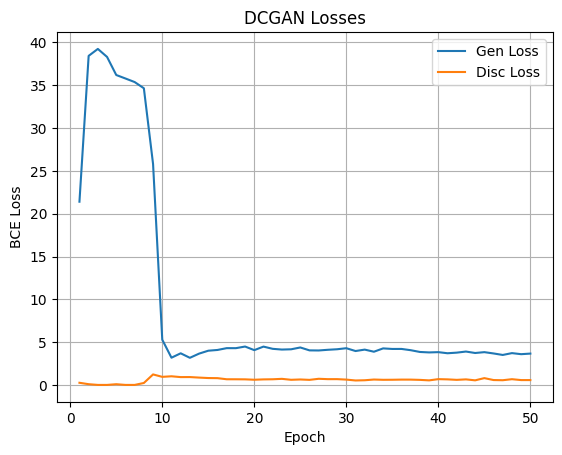

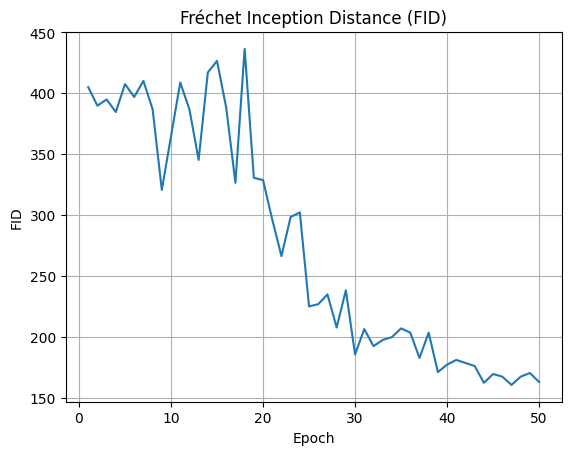

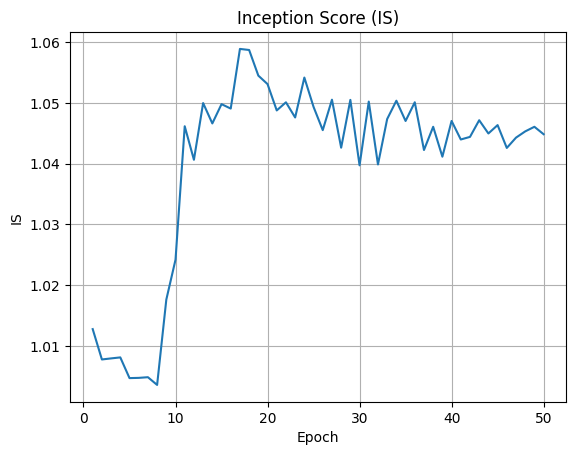

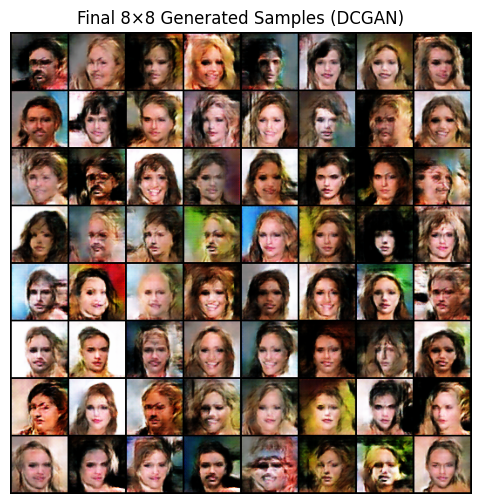

In [ ]:
# AFTER TRAINING PLOTS
epochs_range = list(range(1, num_epochs + 1))

plt.figure()
plt.plot(epochs_range, G_losses, label='Gen Loss')
plt.plot(epochs_range, D_losses, label='Disc Loss')
plt.title("DCGAN Losses")
plt.xlabel("Epoch"); plt.ylabel("BCE Loss")
plt.legend(); plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs_range, FID_scores)
plt.title("Fréchet Inception Distance (FID)")
plt.xlabel("Epoch"); plt.ylabel("FID")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs_range, IS_scores)
plt.title("Inception Score (IS)")
plt.xlabel("Epoch"); plt.ylabel("IS")
plt.grid(True)
plt.show()

import torchvision.utils as vutils

# Generate 64 images from final generator
netG.eval()
with torch.no_grad():
    z = torch.randn(64, nz, 1, 1, device=device)
    fake_imgs = netG(z).cpu()

# Make grid and show
grid = vutils.make_grid(fake_imgs, nrow=8, padding=2, normalize=True)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Final 8×8 Generated Samples (DCGAN)")
plt.show()

